In [1]:
from lxml.html import parse
from urllib2 import urlopen
from os.path import getsize
from math import log
from pandas import Series, DataFrame
import pandas as pd
import urllib 

ImportError: No module named 'urllib2'

In [2]:
data_high=pd.read_csv("data/sh600030_成交明细_2015-11-2.csv",encoding="gbk",index_col=0,parse_dates=True)
#这里因为我们小组没有找到好的高频数据下载的网站，所以没有整理出高频数据的表格。
#所以我在这里自己从新浪找了600030股票在2015年11月2日这一天的高频数据。
data_high_onemin=data_high['price'].resample("1min",how="mean")
onemin=data_high_onemin/data_high_onemin.shift(1)
data_high_tenmin=data_high['price'].resample("10min",how="mean")
tenmin=data_high_tenmin/data_high_tenmin.shift(1)
data_high_fifteenmin=data_high['price'].resample("15min",how="mean")
fifteenmin=data_high_fifteenmin/data_high_fifteenmin.shift(1)
data_high_thirtymin=data_high['price'].resample("30min",how="mean")
thirtymin=data_high_thirtymin/data_high_thirtymin.shift(1)
#简单收益率：
oneminsimple=onemin-1
tenminsimple=tenmin-1
fifteensimple=fifteenmin-1
thirtyminsimple=thirtymin-1
#对数收益率：
oneminlog=onemin.map(log)
tenminlog=tenmin.map(log)
fifteenminlog=fifteenmin.map(log)
thirtyminlog=thirtymin.map(log)


NameError: name 'pd' is not defined

In [41]:
def get_sina_stock(stockid,start="1990-12-19",end=pd.datetime.now(),isstock=True,fuquan=True):    
    def _unpack(row, kind='td'):
        elts = row.findall('.//%s' % kind)
        return [val.text_content().strip() for val in elts] # .strip()去掉\r\t\n之类的字符    
    def parse_options_data(table,isstock,fuquan):
        rows = table.findall('.//tr')
        data = [_unpack(r) for r in rows[2:]]
        if isstock & fuquan:
            colnames = ['date','open','high','close','low','vol','amount','ratio'] # 回避中文处理
        else:
            colnames = ['date','open','high','close','low','vol','amount']
        data= pd.DataFrame(data,columns=colnames)
        data.index=pd.to_datetime(data["date"])
        data=data.drop("date",axis=1)
        data=data.ix[range(len(data)-1,-1,-1)]
        return  data
    data=pd.DataFrame()
    daterange=pd.date_range(start,end,freq="Q")
    daterange=daterange.insert(len(daterange),daterange[-1]+1)
    for cq in daterange: 
        if isstock:
            if fuquan:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_FuQuanMarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
            else:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)            
        else:            
            url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'/type/S.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
        try:
            parsed = parse(urlopen(url))
        except:
            print "download failed for year=" +str(cq.year)+',  jidu='+str(cq.month/3)
            continue
        doc = parsed.getroot()
        tables=doc.findall('.//table')     
        da= tables[-1] # last table 19 for fuquan data and 4 for index
        datatem = parse_options_data(da,isstock,fuquan)
        data=pd.concat([data,datatem])
    return pd.DataFrame(data[start:end],dtype=float)

data=get_sina_stock(601899,"2013-11-2","2015-11-2")
day=data['close']/data['close'].shift(1)
data_week=data['close'].resample("W-FRI",how="mean")
week=data_week/data_week.shift(1)
data_month=data['close'].resample("M",how="mean")
month=data_month/data_month.shift(1)
data_quarter=data['close'].resample("Q",how="mean")
quarter=data_quarter/data_quarter.shift(1)
data_year=data['close'].resample("A",how="mean")
year=data_year/data_year.shift(1)
#简单收益率：
daysimple=day-1
weeksimple=week-1
monthsimple=month-1
quartersimple=quarter-1
yearsimple=year-1
#对数收益率：
daylog=day.map(log)
weeklog=week.map(log)
monthlog=month.map(log)
quarterlog=quarter.map(log)
yearlog=year.map(log)

In [42]:
#公式：r10(10分钟对数收益率)=log(R5（前5分钟简单收益率）*R5'（后5分钟简单收益率）)
def fivetoten(R5):
    r10=(R5*R5.shift(1)).applymap(log)
    return r10
data_high_fivemin=data_high['price'].resample("5min",how="mean")
fivemin=data_high_fivemin/data_high_fivemin.shift(1)
fivemin_frame=DataFrame(fivemin.values,columns=['price'],index=fivemin.index)
fivetoten(fivemin_frame)

,price
time,
2015-11-03 09:25:00,NaN
2015-11-03 09:30:00,NaN
2015-11-03 09:35:00,0.001425
2015-11-03 09:40:00,0.002213
2015-11-03 09:45:00,0.002934
2015-11-03 09:50:00,0.004263
2015-11-03 09:55:00,0.002465
2015-11-03 10:00:00,-0.000838
2015-11-03 10:05:00,-0.002961


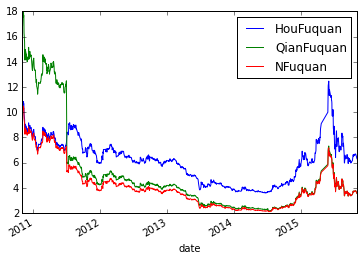

In [43]:
%matplotlib inline 
data_NF=get_sina_stock(601899,"2010-11-02","2015-11-2",fuquan=False)
data_HF=get_sina_stock(601899,"2010-11-2","2015-11-2")
data_HF2=data_HF['ratio']*data_NF['close']
a=data_HF['ratio'].max()
data_QF=data_NF['close']*a/data_HF['ratio']
data_All=pd.concat([data_HF2,data_QF,data_NF['close']],axis=1)
data_All.columns=["HouFuquan","QianFuquan","NFuquan"]
data_All.plot()

In [54]:
x=data_HF2-data_NF['close']
x[(x-x.shift(1))>0.5]

date
2011-07-04    3.02544
dtype: float64

In [53]:
#由上面两个Series可见该股票在2011年7月4日复权价格与不复权价格产生了较大差异，应该是进行了股权交易。
#下面是利用助教给出的程序代码抓取的股票的财务数据，可见2011年7月4号确实发生了股权变动。
from urllib2 import urlopen
from bs4 import BeautifulSoup
import urllib 
import re

sid = "601899" # Just change the code of the stock here.
url = "http://money.finance.sina.com.cn/corp/go.php/vISSUE_ShareBonus/stockid/601899.phtml"
soup = BeautifulSoup(urlopen(url))
tab = soup.find(id='sharebonus_1')

td_th = re.compile('t[dh]')

cells =pd.DataFrame( [[row.findAll(td_th)[i].find(text=True) for row in tab.findAll("tr")[3:]] for i in range(0,9)]).T
cells.columns = [u"公告日期",u"送股(每10股)",u"转增(每10股)",u"派息(每10股)",u"进度",u"除权除息日",u"股权登记日",u"红股上市日",u"查看详细"]
cells

,公告日期,送股(每10股),转增(每10股),派息(每10股),进度,除权除息日,股权登记日,红股上市日,查看详细
0,2015-07-03,0,0,0.8,实施,2015-07-09,2015-07-08,--,查看
1,2014-06-30,0,0,0.8,实施,2014-07-07,2014-07-04,--,查看
2,2013-06-29,0,0,1,实施,2013-07-05,2013-07-04,--,查看
3,2012-06-29,0,0,1,实施,2012-07-06,2012-07-05,--,查看
4,2011-06-27,0,5,1,实施,2011-07-04,2011-07-01,--,查看
5,2010-06-04,0,0,1,实施,2010-06-10,2010-06-09,--,查看
6,2009-05-25,0,0,1,实施,2009-06-03,2009-06-02,--,查看
7,2008-07-11,0,0,0.9,实施,2008-07-18,2008-07-17,--,查看
